In [1]:
import io
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import wntr
import scipy as sc
import networkx as nx
import networkx.drawing.nx_pylab as nxp
from pipedream_solver.hydraulics import SuperLink
from pipedream_solver.simulation import Simulation
from pipedream_solver.nutils import interpolate_sample
import random
import time
import pickle
import pipedream_utility as pdu
from pipedream_utility import *
import pipedream_simulation as pd_sim
from pipedream_simulation import *
import pipedream_simulation_sensor_results as pd_sim_sensor
from pipedream_simulation_sensor_results import *
from pipedream_kalman_filter import apply_EKF
import viswaternet as vis

#Don't show future warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
images_dir = 'img/'
 
# INPUTS ######################################################################
sensors_list = []  
max_sensors = 2
percentile = 90
cutoff_timestep = 5
metric = 'mean'
percent = True
Rcov_case = 1
banded = False
source_node = True

t_run = 24
dt = 1800
Rcov_case=1

In [2]:
inp = 'PA1'
inp_path = f'./networks/{inp}.inp'

In [3]:
wn = wntr.network.WaterNetworkModel(inp_path)

In [4]:
sensor_list = ['433', '221', '190', '163', '293']

In [5]:
#### MAKE SURE THIS DOESN'T GET DUPLICATED
known_measurements_list = ['338', '186']
msmts = known_measurements_list + sensor_list

In [6]:
m = len(msmts)
n = wn.num_nodes + wn.num_tanks # we are adding the "fake" nodes connected to tank orifices

In [7]:
sensor_std_dev = 0.1

In [8]:
Qcov = (10) * np.eye(n)

In [9]:
kf = {}

for i in range(len(msmts)):
    print('Sensors: ', i)
    subset = msmts[:i+1]
    Rcov = (0.5**2) * np.eye(i + 1)
    H_df_kf, H_df_real, H_df_model, H_df_sensor, model = apply_EKF(inp_path, subset, t_run=t_run, dt=dt,
                                                                   banded=banded, Rcov=Rcov, Qcov=Qcov, sensor_std_dev=sensor_std_dev, 
                                                                   num_iter=40)
    kf[i+1] = H_df_kf
kf[0] = H_df_model

Sensors:  0
Sensors:  1
Sensors:  2
Sensors:  3
Sensors:  4
Sensors:  5
Sensors:  6


In [10]:
%matplotlib inline

In [11]:
np.abs(H_df_kf - H_df_real).mean().mean()

0.2868047772833874

In [12]:
np.abs(H_df_model - H_df_real).mean().mean()

1.9465749358956255

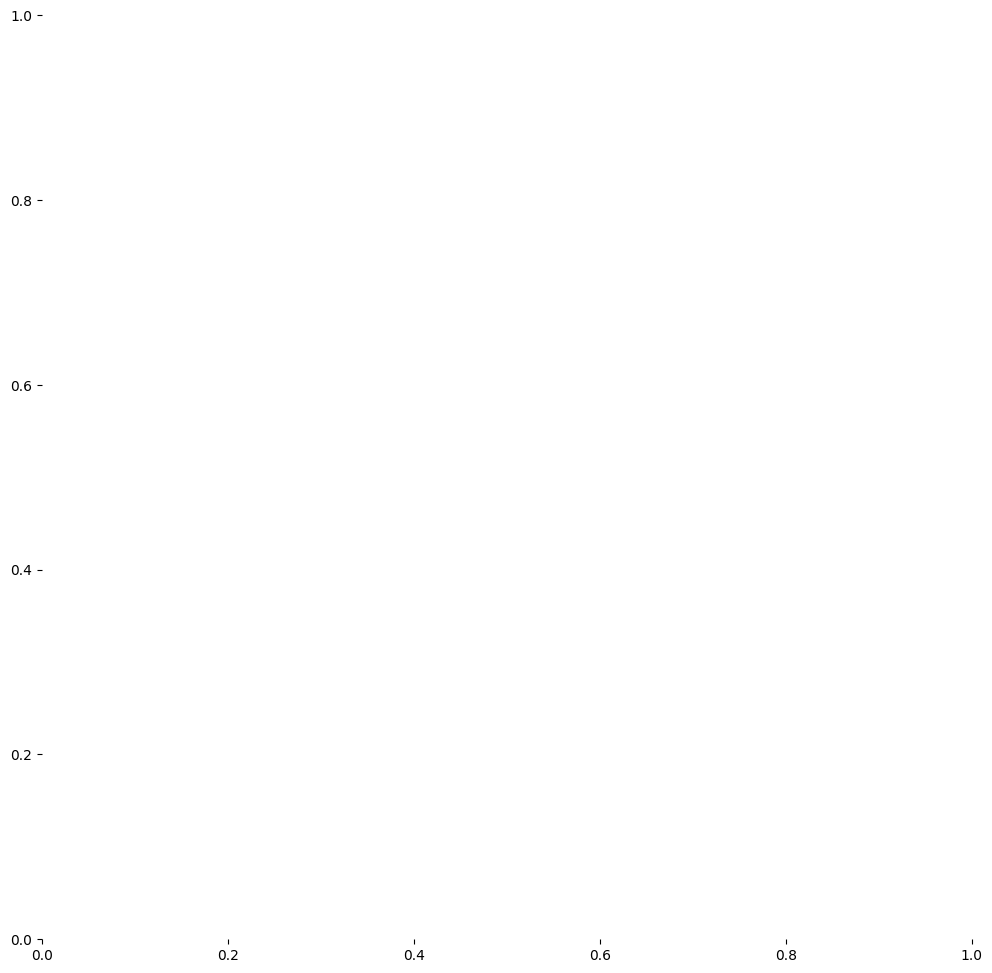

In [13]:
vis_model = vis.VisWNModel(inp_path)

In [14]:
mads = {}

In [15]:
junction_names = model.superjunctions['name'].iloc[:-2].values

In [16]:
max_limit = np.abs(H_df_model - H_df_real).loc[:, junction_names].mean(axis=0).max()

In [17]:
k = 0
H_df = kf[k]
err = np.abs(H_df - H_df_real).mean(axis=0).loc[junction_names].values
mads[k] = err

Text(0.5, 1.0, 'MAD between model and ground truth (0 sensors)')

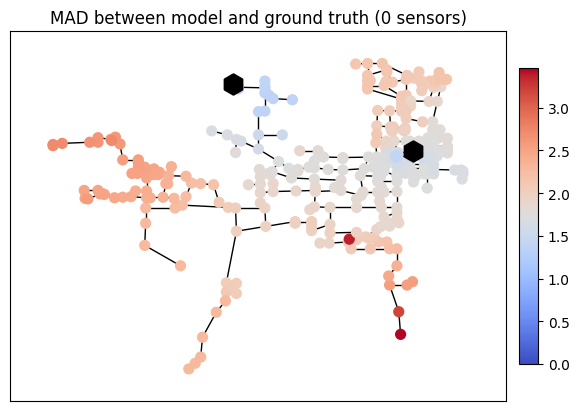

In [18]:
fig, ax = plt.subplots()
cmap = 'coolwarm'
node_size=200
vis_model.plot_unique_data(ax=ax, parameter = "custom_data", parameter_type = 'node', 
                           custom_data_values = [junction_names, err], data_type = 'continuous', 
                           cmap = cmap, vmin = 0, vmax = max_limit, draw_color_bar = True,  
                           node_size = node_size, draw_base_legend=False, tank_color='k')
ax.set_title('MAD between model and ground truth (0 sensors)')

In [19]:
k = 1
H_df = kf[k]
err = np.abs(H_df - H_df_real).mean(axis=0).loc[junction_names].values

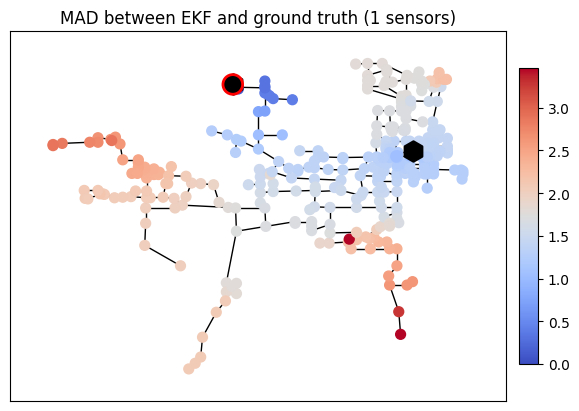

In [20]:
fig, ax = plt.subplots()
cmap = 'coolwarm'
node_size=200
vis_model.plot_unique_data(ax=ax, parameter = "custom_data", parameter_type = 'node', 
                           custom_data_values = [junction_names, err], data_type = 'continuous', 
                           cmap = cmap, vmin = 0, vmax = max_limit, draw_color_bar = True,  
                           node_size = node_size, draw_base_legend=False, tank_color='k')
vis_model.draw_nodes(ax=ax, node_list=msmts[:k], node_color="none", node_size=800, edge_colors='r', line_widths=2)
ax.set_title(f'MAD between EKF and ground truth ({k} sensors)')
mads[k] = err

In [21]:
k = 2
H_df = kf[k]
err = np.abs(H_df - H_df_real).mean(axis=0).loc[junction_names].values

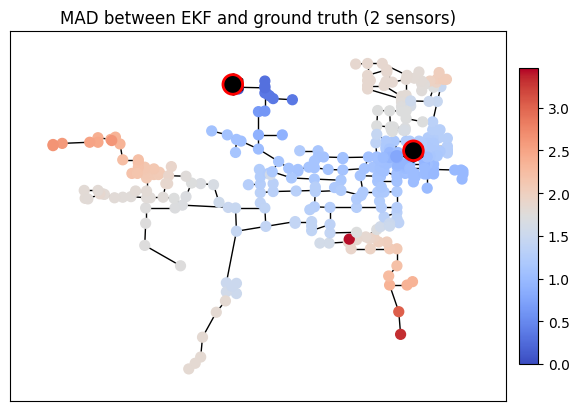

In [22]:
fig, ax = plt.subplots()
cmap = 'coolwarm'
node_size=200
vis_model.plot_unique_data(ax=ax, parameter = "custom_data", parameter_type = 'node', 
                           custom_data_values = [junction_names, err], data_type = 'continuous', 
                           cmap = cmap, vmin = 0, vmax = max_limit, draw_color_bar = True,  
                           node_size = node_size, draw_base_legend=False, tank_color='k')
vis_model.draw_nodes(ax=ax, node_list=msmts[:k], node_color="none", node_size=800, edge_colors='r', line_widths=2)
ax.set_title(f'MAD between EKF and ground truth ({k} sensors)')
mads[k] = err

In [23]:
k = 3
H_df = kf[k]
err = np.abs(H_df - H_df_real).mean(axis=0).loc[junction_names].values

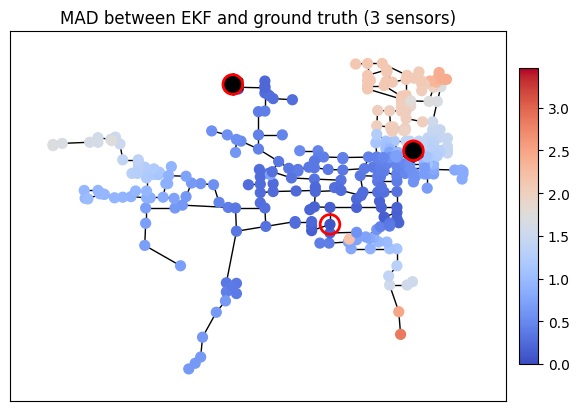

In [24]:
fig, ax = plt.subplots()
cmap = 'coolwarm'
node_size=200
vis_model.plot_unique_data(ax=ax, parameter = "custom_data", parameter_type = 'node', 
                           custom_data_values = [junction_names, err], data_type = 'continuous', 
                           cmap = cmap, vmin = 0, vmax = max_limit, draw_color_bar = True,  
                           node_size = node_size, draw_base_legend=False, tank_color='k')
vis_model.draw_nodes(ax=ax, node_list=msmts[:k], node_color="none", node_size=800, edge_colors='r', line_widths=2)
ax.set_title(f'MAD between EKF and ground truth ({k} sensors)')
mads[k] = err

In [25]:
k = 4
H_df = kf[k]
err = np.abs(H_df - H_df_real).mean(axis=0).loc[junction_names].values

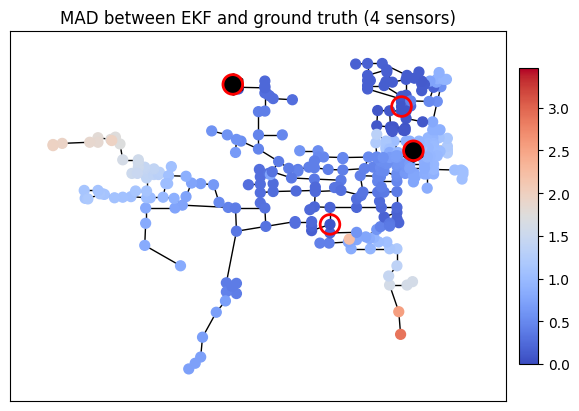

In [26]:
fig, ax = plt.subplots()
cmap = 'coolwarm'
node_size=200
vis_model.plot_unique_data(ax=ax, parameter = "custom_data", parameter_type = 'node', 
                           custom_data_values = [junction_names, err], data_type = 'continuous', 
                           cmap = cmap, vmin = 0, vmax = max_limit, draw_color_bar = True,  
                           node_size = node_size, draw_base_legend=False, tank_color='k')
vis_model.draw_nodes(ax=ax, node_list=msmts[:k], node_color="none", node_size=800, edge_colors='r', line_widths=2)
ax.set_title(f'MAD between EKF and ground truth ({k} sensors)')
mads[k] = err

In [27]:
k = 5
H_df = kf[k]
err = np.abs(H_df - H_df_real).mean(axis=0).loc[junction_names].values

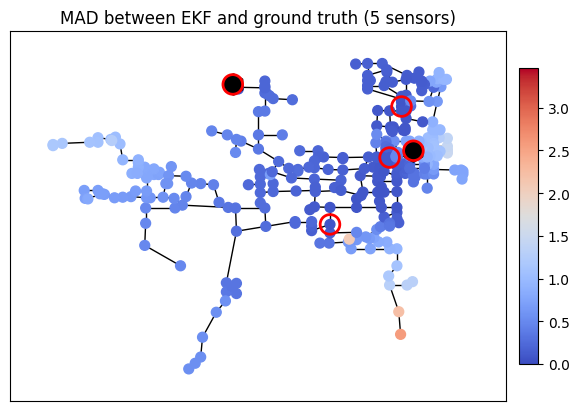

In [28]:
fig, ax = plt.subplots()
cmap = 'coolwarm'
node_size=200
vis_model.plot_unique_data(ax=ax, parameter = "custom_data", parameter_type = 'node', 
                           custom_data_values = [junction_names, err], data_type = 'continuous', 
                           cmap = cmap, vmin = 0, vmax = max_limit, draw_color_bar = True,  
                           node_size = node_size, draw_base_legend=False, tank_color='k')
vis_model.draw_nodes(ax=ax, node_list=msmts[:k], node_color="none", node_size=800, edge_colors='r', line_widths=2)
ax.set_title(f'MAD between EKF and ground truth ({k} sensors)')
mads[k] = err

In [29]:
k = 6
H_df = kf[k]
err = np.abs(H_df - H_df_real).mean(axis=0).loc[junction_names].values

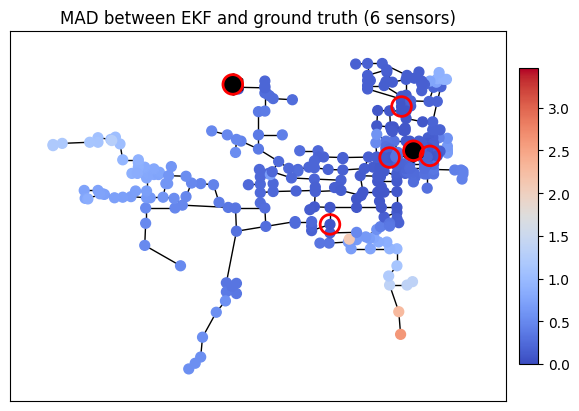

In [30]:
fig, ax = plt.subplots()
cmap = 'coolwarm'
node_size=200
vis_model.plot_unique_data(ax=ax, parameter = "custom_data", parameter_type = 'node', 
                           custom_data_values = [junction_names, err], data_type = 'continuous', 
                           cmap = cmap, vmin = 0, vmax = max_limit, draw_color_bar = True,  
                           node_size = node_size, draw_base_legend=False, tank_color='k')
vis_model.draw_nodes(ax=ax, node_list=msmts[:k], node_color="none", node_size=800, edge_colors='r', line_widths=2)
ax.set_title(f'MAD between EKF and ground truth ({k} sensors)')
mads[k] = err

In [31]:
k = 7
H_df = kf[k]
err = np.abs(H_df - H_df_real).mean(axis=0).loc[junction_names].values

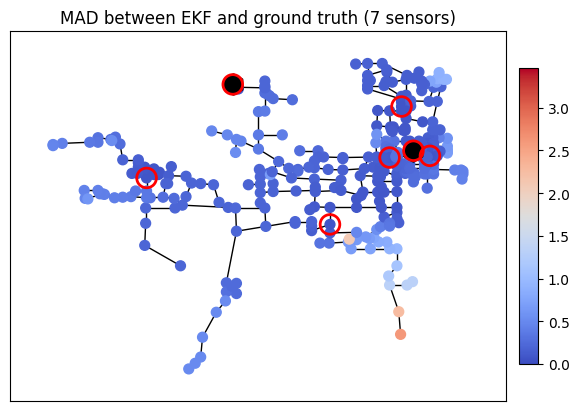

In [32]:
fig, ax = plt.subplots()
cmap = 'coolwarm'
node_size=200
vis_model.plot_unique_data(ax=ax, parameter = "custom_data", parameter_type = 'node', 
                           custom_data_values = [junction_names, err], data_type = 'continuous', 
                           cmap = cmap, vmin = 0, vmax = max_limit, draw_color_bar = True,  
                           node_size = node_size, draw_base_legend=False, tank_color='k')
vis_model.draw_nodes(ax=ax, node_list=msmts[:k], node_color="none", node_size=800, edge_colors='r', line_widths=2)
ax.set_title(f'MAD between EKF and ground truth ({k} sensors)')
mads[k] = err

Text(0.5, 1.0, 'PA1: Mean absolute deviation in nodal heads (m)')

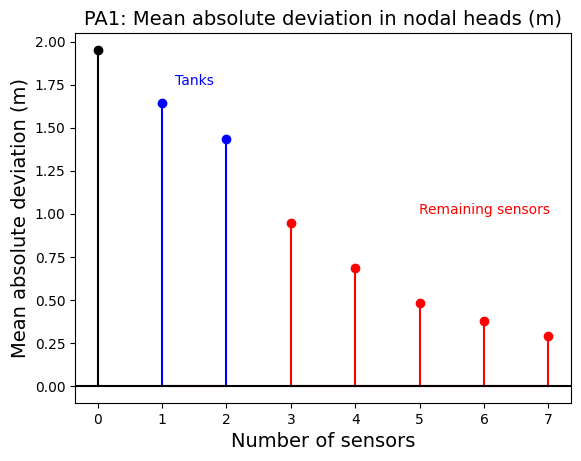

In [33]:
plt.stem([0], [mads[0].mean()], linefmt='k')
plt.stem(np.arange(1, 1 + wn.num_tanks), [mads[i].mean() for i in range(1, 1+wn.num_tanks)], linefmt='b')
#plt.stem(np.arange(1 + wn.num_tanks, 1 + len(known_measurements_list)),
#         [mads[i].mean() for i in range(1 + wn.num_tanks, 1 + len(known_measurements_list))], linefmt='g')
plt.stem(np.arange(1 + len(known_measurements_list), 8),
         [mads[i].mean() for i in range(1 + len(known_measurements_list), 8)], linefmt='r')
plt.axhline(0, c='k')
plt.text(1.5, 1.75, 'Tanks', c='b', ha='center')
#plt.text(3, 1.4, 'Source', c='g', ha='center')
plt.text(6, 1.0, 'Remaining sensors', c='r', ha='center')
plt.xlabel('Number of sensors', size=14)
plt.ylabel('Mean absolute deviation (m)', size=14)
plt.title('PA1: Mean absolute deviation in nodal heads (m)', size=14)

In [34]:
validation_node_list = ['29', '311', '336', '641']

In [35]:
import seaborn as sns

In [36]:
sns.set_palette('spring', 8)

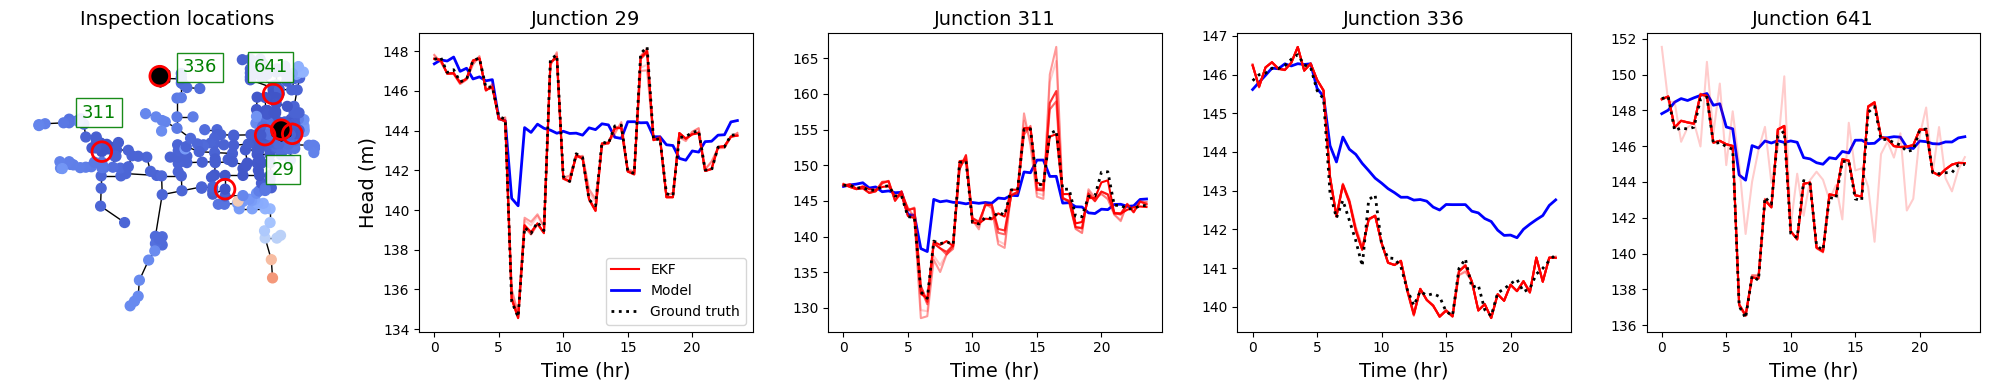

In [37]:
fig, ax = plt.subplots(1, 5, figsize=(20, 4))

cmap = 'coolwarm'
buffer_distance=200
vis_model.plot_unique_data(ax=ax[0], parameter = "custom_data", parameter_type = 'node', 
                           custom_data_values = [junction_names, err], data_type = 'continuous', 
                           cmap = cmap, vmin = 0, vmax = max_limit, draw_color_bar = False,  
                           node_size = node_size, draw_base_legend=False, tank_color='k')
vis_model.draw_nodes(ax=ax[0], node_list=msmts[:k], node_color="none", node_size=800, edge_colors='r', line_widths=2)
for index, name in enumerate(validation_node_list):
    ax[0].text(wn.get_node(name).coordinates[0]+buffer_distance, wn.get_node(name).coordinates[1]+buffer_distance, name, color='g' , fontsize = 13, 
                   bbox=dict(facecolor='white', alpha = 0.9, edgecolor='g'))
ax[0].set_title('Inspection locations', size=14)
ax[0].set_frame_on(False) 

for index, name in enumerate(validation_node_list):
    for i in range(1, 5):
        ax.flat[index+1].plot(kf[2+i][name].index / 3600, kf[2+i][name].values, c='r', alpha=0.2*i, label='_nolegend', zorder=i)
    ax.flat[index+1].plot(kf[7][name].index / 3600, kf[7][name].values, c='r', label='EKF', zorder=i + 1)

    ax.flat[index+1].plot(kf[0][name].index / 3600, kf[0][name].values, c='b', linewidth=2, label='Model', zorder=0)
    ax.flat[index+1].plot(H_df_real[name].index / 3600, H_df_real[name].values, c='k', linewidth=2, linestyle=':', label='Ground truth', zorder=i + 2)
    ax.flat[index+1].set_title(f'Junction {name}', size=14)
    ax.flat[index+1].set_xlabel('Time (hr)', size=14)
    if not index:
        ax.flat[index+1].legend()
        ax.flat[index+1].set_ylabel('Head (m)', size=14)
plt.tight_layout()


In [38]:
q_list = [10**i for i in range(-10,3)]

kf_q = {}
mads_q = {}
ratio_q = []
error_q = []

for i in range(len(q_list)):
    print('Sensors: ', i)
    subset = msmts
    Qcov = (q_list[i]) * np.eye(n)
    Rcov = (0.5**2) * np.eye(len(msmts))
    ratio_q.append(q_list[i]/0.5**2)
    #Rcov = (1**2) * np.eye(len(msmts))
    H_df_kf, H_df_real, H_df_model, H_df_sensor, model = apply_EKF(inp_path, subset, t_run=t_run, dt=dt,
                                                                   banded=banded, Rcov=Rcov, Qcov=Qcov, sensor_std_dev=sensor_std_dev, 
                                                                   num_iter=40)
    kf_q[i+1] = H_df_kf
    mads_q[i+1] = np.abs(H_df_kf - H_df_model).mean(axis=0).loc[junction_names].values
    error_q.append(mads_q[i+1].mean())
kf[0] = H_df_model

Sensors:  0
Sensors:  1
Sensors:  2
Sensors:  3
Sensors:  4
Sensors:  5
Sensors:  6
Sensors:  7
Sensors:  8
Sensors:  9
Sensors:  10
Sensors:  11
Sensors:  12


## Figure 7: Sensitivity of EKF estimates to process and measurement noise: mean abosolute difference in pressure heads between hydraulic model and EKF estimates

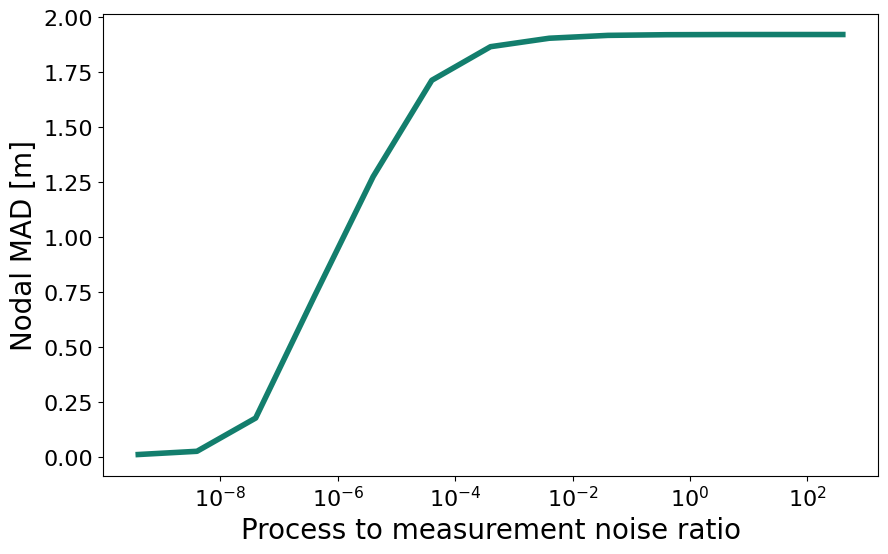

In [39]:
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(ratio_q, error_q, lw = 4, c = 'xkcd:blue green')
ax.set_xscale('log')
ax.set_ylabel('Nodal MAD [m]', fontsize = 20)
ax.set_xlabel('Process to measurement noise ratio', fontsize = 20)
ax.tick_params(axis='both', which = 'major', labelsize = 16)
plt.savefig('img/proc_meas_noise_ratio.pdf')

In [40]:
Qcov_list = [0.0005**2, 0.005**2, 100]

kf = {}
mads = {}

for i in range(len(Qcov_list)):
    print('Sensors: ', i)
    subset = msmts
    Qcov = (Qcov_list[i]) * np.eye(n)
    #Rcov = (0.5**2) * np.eye(len(msmts))
    Rcov = (10) * np.eye(len(msmts))
    H_df_kf, H_df_real, H_df_model, H_df_sensor, model = apply_EKF(inp_path, subset, t_run=t_run, dt=dt,
                                                                   banded=banded, Rcov=Rcov, Qcov=Qcov, sensor_std_dev=sensor_std_dev, 
                                                                   num_iter=40)
    kf[i+1] = H_df_kf
    mads[i+1] = np.abs(H_df_kf - H_df_real).mean(axis=0).loc[junction_names].values
kf[0] = H_df_model

Sensors:  0
Sensors:  1
Sensors:  2


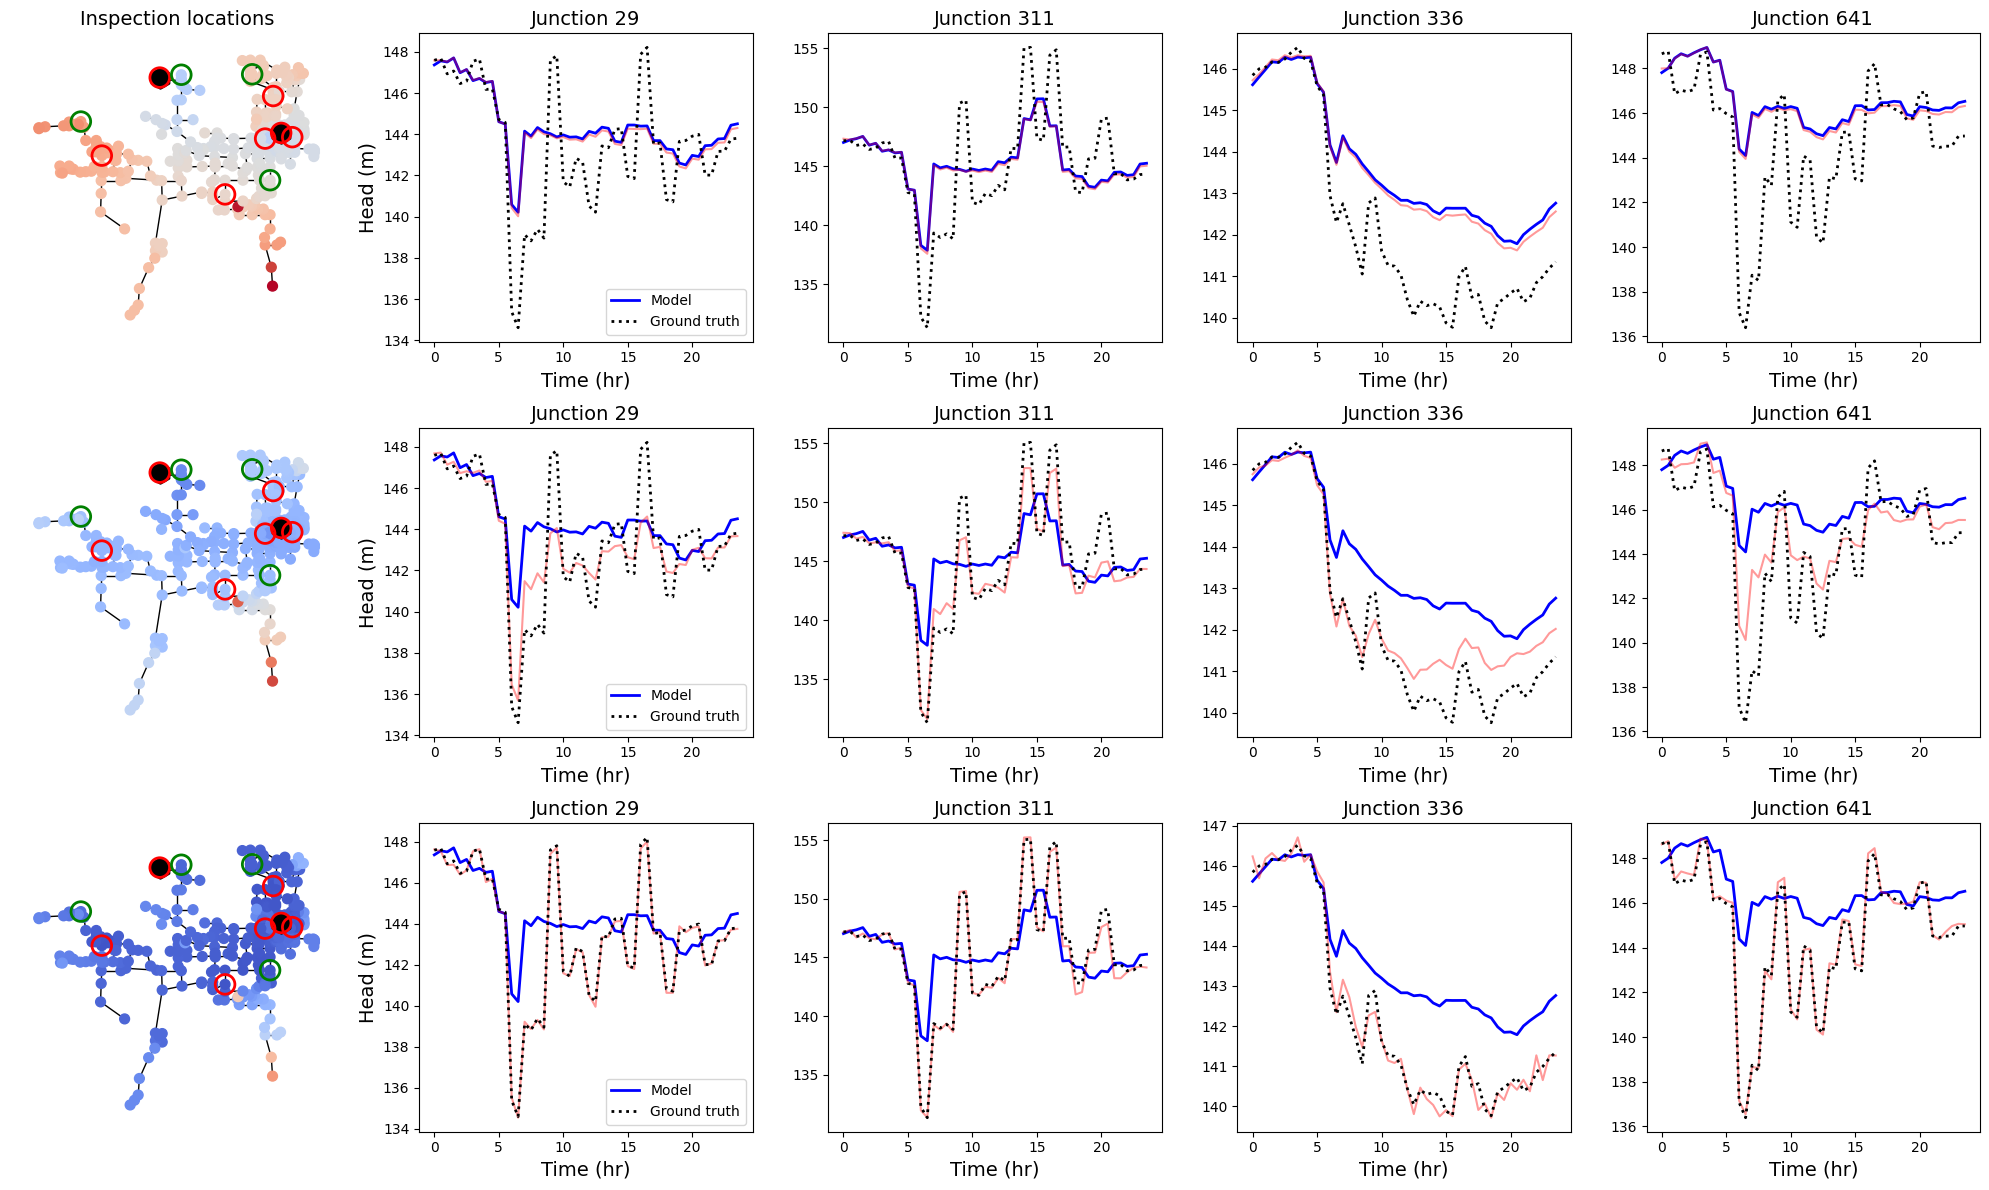

In [41]:
fig, ax = plt.subplots(3, 5, figsize=(20, 12))

cmap = 'coolwarm'
buffer_distance=200
for i in range(3):
    vis_model.plot_unique_data(ax=ax[i][0], parameter = "custom_data", parameter_type = 'node', 
                               custom_data_values = [junction_names, mads[i+1]], data_type = 'continuous', 
                               cmap = cmap, vmin = 0, vmax = max_limit, draw_color_bar = False,  
                               node_size = node_size, draw_base_legend=False, tank_color='k')
    vis_model.draw_nodes(ax=ax[i][0], node_list=msmts, node_color="none", node_size=800, edge_colors='r', line_widths=2)
    vis_model.draw_nodes(ax=ax[i][0], node_list=validation_node_list, node_color="none", node_size=800, edge_colors='g', line_widths=2)
   # for index, name in enumerate(validation_node_list):
   #     ax[i][0].text(wn.get_node(name).coordinates[0]+buffer_distance, wn.get_node(name).coordinates[1]+buffer_distance, name, color='g' , fontsize = 13, 
   #                    bbox=dict(facecolor='white', alpha = 0.9, edgecolor='g'))
    ax[i][0].set_frame_on(False) 
ax[0][0].set_title('Inspection locations', size=14)


for index, name in enumerate(validation_node_list):
    for j in range(3):
        ax[j][index+1].plot(kf[j+1][name].index / 3600, kf[j+1][name].values, c='r', alpha=0.2*i, label='_nolegend', zorder=i)
        #ax.flat[index+1].plot(kf[7][name].index / 3600, kf[7][name].values, c='r', label='EKF', zorder=i + 1)

        ax[j][index+1].plot(kf[0][name].index / 3600, kf[0][name].values, c='b', linewidth=2, label='Model', zorder=0)
        ax[j][index+1].plot(H_df_real[name].index / 3600, H_df_real[name].values, c='k', linewidth=2, linestyle=':', label='Ground truth', zorder=i + 2)
        ax[j][index+1].set_title(f'Junction {name}', size=14)
        ax[j][index+1].set_xlabel('Time (hr)', size=14)
        if not index:
            ax[j][index+1].legend()
            ax[j][index+1].set_ylabel('Head (m)', size=14)
    plt.tight_layout()


## Figure 6: Sensitivity of EKF estimates to process noise: (top) low, (middle) medium, and (bottom) high process noise at holdout locations (Nodes 29, 311, 366, and 641) in PA1. Hydraulic model (blue), true heads (dotted black), and EKF estimates (red).

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


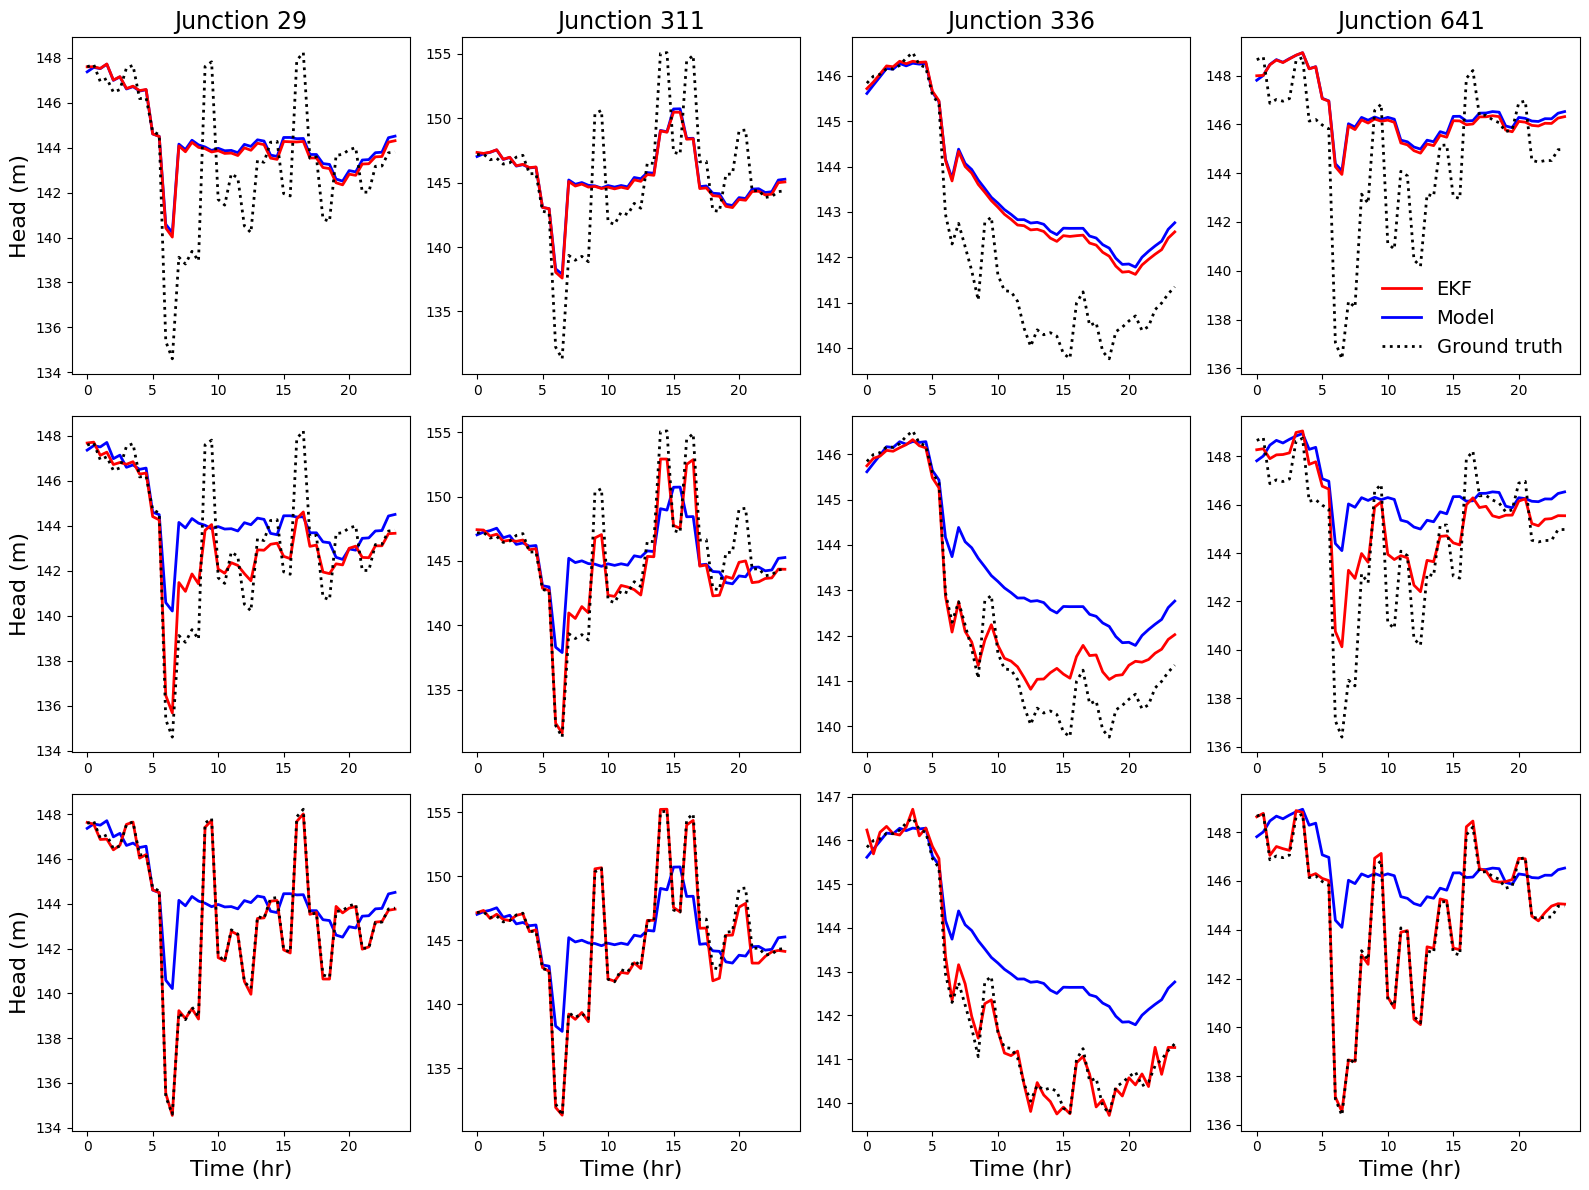

In [42]:
fig, ax = plt.subplots(3, 4, figsize=(16, 12))

cmap = 'coolwarm'
buffer_distance=200
#for i in range(3):
#    vis_model.plot_unique_data(ax=ax[i][0], parameter = "custom_data", parameter_type = 'node', 
#                               custom_data_values = [junction_names, mads[i+1]], data_type = 'continuous', 
#                               cmap = cmap, vmin = 0, vmax = max_limit, draw_color_bar = False,  
#                               node_size = node_size, draw_base_legend=False, tank_color='k')
#    vis_model.draw_nodes(ax=ax[i][0], node_list=msmts, node_color="none", node_size=800, edge_colors='r', line_widths=2)
#    vis_model.draw_nodes(ax=ax[i][0], node_list=validation_node_list, node_color="none", node_size=800, edge_colors='g', line_widths=2)
   # for index, name in enumerate(validation_node_list):
   #     ax[i][0].text(wn.get_node(name).coordinates[0]+buffer_distance, wn.get_node(name).coordinates[1]+buffer_distance, name, color='g' , fontsize = 13, 
   #                    bbox=dict(facecolor='white', alpha = 0.9, edgecolor='g'))
#    ax[i][0].set_frame_on(False) 
#ax[0][0].set_title('Inspection locations', size=14)


for index, name in enumerate(validation_node_list):
    for j in range(3):
        ax[j][index].plot(kf[i][name].index / 3600, kf[j+1][name].values, c='r', linewidth=2, label='EKF', zorder=i)
        #ax.flat[index+1].plot(kf[7][name].index / 3600, kf[7][name].values, c='r', label='EKF', zorder=i + 1)

        ax[j][index].plot(kf[0][name].index / 3600, kf[0][name].values, c='b', linewidth=2, label='Model', zorder=0)
        ax[j][index].plot(H_df_real[name].index / 3600, H_df_real[name].values, c='k', linewidth=2, linestyle=':', label='Ground truth', zorder=i + 2)
        if j == 0:
            ax[j][index].set_title(f'Junction {name}', size=17)
        if j == 2:
            ax[j][index].set_xlabel('Time (hr)', size=16)
        if not index:
            ax[j][index].set_ylabel('Head (m)', size=16)
    ax[0][3].legend(frameon=False, fontsize = 14)

    plt.tight_layout()
plt.savefig('img/ekf_sensitivity_PA1.pdf', bbox_inches='tight')